<a href="https://colab.research.google.com/github/DamodaraBarbosa/eleicoes_ceara_2022/blob/main/06_governador_analysis_eleicoes_ceara_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas geobr descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importando as bibliotecas

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from geobr import read_municipality
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [3]:
import warnings

warnings.filterwarnings("ignore")

# 1. Carregando os dados no *dataframe*

In [4]:
votacao_ce = pd.read_csv(
    '/content/drive/MyDrive/Datasets/votacao_secao_2022_CE_tratado.csv',
    sep= ',', encoding= 'latin-1'
)

In [5]:
votacao_ce.head(3)

,nm_municipio,nr_zona,nr_secao,ds_cargo,nr_votavel,nm_votavel,qt_votos
0,FORTALEZA,94,6,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,4
1,RUSSAS,9,266,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,13
2,PARAIPABA,109,119,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,3


# 2. Informações do *dataframe*

## 2.1 Dimensões do *dataframe*

Definir as dimensões de um *dataframe* é indicar o número de colunas e linhas do mesmo. 

In [6]:
f'O dataframe contém {votacao_ce.shape[1]} colunas e {votacao_ce.shape[0]} linhas.'

'O dataframe contém 7 colunas e 2509903 linhas.'

## 2.2 Infos do *dataframe*

In [7]:
votacao_ce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509903 entries, 0 to 2509902
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   nm_municipio  object
 1   nr_zona       int64 
 2   nr_secao      int64 
 3   ds_cargo      object
 4   nr_votavel    int64 
 5   nm_votavel    object
 6   qt_votos      int64 
dtypes: int64(4), object(3)
memory usage: 134.0+ MB


## 2.3 Dados faltantes

É importante identificar a presença de dados faltantes ("not a number" ou `NaN`).

In [8]:
votacao_ce.isna().sum()

nm_municipio    0
nr_zona         0
nr_secao        0
ds_cargo        0
nr_votavel      0
nm_votavel      0
qt_votos        0
dtype: int64

Não há em nenhuma das colunas do conjunto de dados a presença de dados faltantes.

## 2.4 Presença de dados duplicados

Para integridade dos dados também é importante detectar se há dados duplicados. Para isso:

In [9]:
votacao_ce.loc[votacao_ce.duplicated()]

,nm_municipio,nr_zona,nr_secao,ds_cargo,nr_votavel,nm_votavel,qt_votos


Não há dados duplicados no conjunto de dados.

# 3. Tratamento dos dados

Os dados referentes às zonas e seções eleitorais apesar serem valores numéricos, são valores categóricos. Portanto, é possível converter esses dados para *string*.

In [10]:
# Usa-se a função astype para converter os dados das duas colunas para string:

votacao_ce['nr_zona'] = votacao_ce['nr_zona'].astype(str)
votacao_ce['nr_secao'] = votacao_ce['nr_secao'].astype(str)

In [11]:
votacao_ce.dtypes

nm_municipio    object
nr_zona         object
nr_secao        object
ds_cargo        object
nr_votavel       int64
nm_votavel      object
qt_votos         int64
dtype: object

# 4. Análise eleitoral

## 4.1 Cargo governador

### 4.1.1 Número de votos por candidato ao governo do estado do Ceará

In [12]:
votos_governador = votacao_ce.query('ds_cargo == "GOVERNADOR"').groupby('nm_votavel')['qt_votos'].sum().sort_values(ascending= False).to_frame()
votos_governador

,qt_votos
nm_votavel,
ELMANO DE FREITAS DA COSTA,2808300
WAGNER SOUSA GOMES,1649213
ROBERTO CLÁUDIO RODRIGUES BEZERRA,734976
VOTO NULO,249099
VOTO BRANCO,175459
FRANCISCO RAIMUNDO MALTA DE ARAÚJO,3015
SERLEY DE SOUSA LEAL,1881
JOSÉ BATISTA NETO,1507


In [13]:
fig = px.bar(
    data_frame= votos_governador,
    y= votos_governador.index,
    x= 'qt_votos',
    color= votos_governador.index,
    text= 'qt_votos',
    title= 'Votos totais por candidato ao cargo de governador do Ceará',
)
fig.update_xaxes(range= [0, 3.5e6])
fig.update_layout(title= {'x': 0.5}, yaxis_title= 'Candidatos', xaxis_title= 'Quantidade de votos', legend_title= 'Candidatos')
fig.update_traces(textfont_size= 12, textangle= 0, textposition= 'outside')
fig.show()

### 4.1.2 Porcentagem de votos totais e válidos ao governo do estado

O número de votos totais de votos para o cargo de governador:

In [14]:
numero_votos_totais = votacao_ce.query('ds_cargo == "GOVERNADOR"')['qt_votos'].sum()
print(f'Votos totais: {numero_votos_totais}')

Votos totais: 5623450


E para determinar o número de votos válidos basta excluir os votos nulos e brancos:

In [15]:
votos_validos = votacao_ce.query('nm_votavel != "VOTO NULO" and nm_votavel != "VOTO BRANCO"')

In [16]:
numero_votos_validos = votos_validos.query('ds_cargo == "GOVERNADOR"')['qt_votos'].sum()
print(f'Votos válidos: {numero_votos_validos}')

Votos válidos: 5198892


A porcentagem é calculada e mostrada na tabela abaixo:

In [17]:
porcentagem_votos_governadores = pd.DataFrame(
    {'Votos válidos':round((votos_validos.query('ds_cargo == "GOVERNADOR"').groupby('nm_votavel')['qt_votos'].sum()/numero_votos_validos) * 100, 2),
     'Votos totais': round((votacao_ce.query('ds_cargo == "GOVERNADOR"').groupby('nm_votavel')['qt_votos'].sum()/numero_votos_totais) * 100, 2)}
).sort_values(['Votos válidos', 'Votos totais'], ascending= False)

In [18]:
porcentagem_votos_governadores = porcentagem_votos_governadores.transpose()
porcentagem_votos_governadores

nm_votavel,ELMANO DE FREITAS DA COSTA,WAGNER SOUSA GOMES,ROBERTO CLÁUDIO RODRIGUES BEZERRA,FRANCISCO RAIMUNDO MALTA DE ARAÚJO,SERLEY DE SOUSA LEAL,JOSÉ BATISTA NETO,VOTO NULO,VOTO BRANCO
Votos válidos,54.02,31.72,14.14,0.06,0.04,0.03,NaN,NaN
Votos totais,49.94,29.33,13.07,0.05,0.03,0.03,4.43,3.12


Por fim, o gráfico mostra a comparação entre os votos totais e válidos.

In [19]:
fig = px.bar(
    data_frame= porcentagem_votos_governadores,
    y= porcentagem_votos_governadores.index,
    x= porcentagem_votos_governadores.columns, text_auto= '.2s',
    title= 'Porcentagem de votos totais e válidos para o cargo de governador do Ceará'
)
fig.update_layout(title= {'x': 0.5}, yaxis_title= '', xaxis_title= 'Porcentagem dos votos', legend_title= 'Candidatos')
fig.show()

## 4.2 Votos para o cargo de governador por município cearense

### 4.2.1 Contribuição de cada município para o panorama geral de votos no estado

Calcula-se o quanto o número de votos no município representa em relação ao total de votos no estado do Ceará. E depois tal valor é convertido em porcentagem:

In [20]:
votos_municipio_pelo_total = votacao_ce.query('ds_cargo == "GOVERNADOR"').groupby('nm_municipio')['qt_votos'].sum()/numero_votos_totais
# selecionam-se os dados referentes aos votos em governador, são agrupados por município e somados.
votos_porcentagem_municipio = round(votos_municipio_pelo_total * 100, 2) # os valores são convertidos em porcentagem.

In [21]:
votos_porcentagem_municipio = pd.DataFrame(votos_porcentagem_municipio.sort_values(ascending= False)) # ordenam-se os dados do maior para o menor.
votos_porcentagem_municipio.head()

,qt_votos
nm_municipio,
FORTALEZA,27.74
CAUCAIA,3.61
JUAZEIRO DO NORTE,2.75
MARACANAÚ,2.64
SOBRAL,2.23


In [22]:
fig = go.Figure()
fig.add_trace(
    go.Waterfall(x= votos_porcentagem_municipio.index, y= votos_porcentagem_municipio['qt_votos'])
)
fig.update_layout(
    title= 'Contribuição de votos, em porcentagem, dos municípios no panorama geral da votação para governador do Ceará',
    title_x= 0.5, yaxis_title= 'Porcentagem', xaxis_title= 'Municípios'
)
fig.show()

Fortaleza, capital do estado, sozinha corresponde a mais de um quarto dos votos (27,74%) e é seguida por outras cidades importantes como Caucaia (3,61%), Juazeiro do Norte (2,75%), Maracanaú (2,64%) e Sobral (2,23%).

### 4.2.2 Quantidade de municípios em que os candidatos venceram 

Selecionam-se os dados referentes ao cargo de governador e agrupam-se esses dados pelo município e nome do candidato. Os votos são, então, somados e o *index* transformado em colunas.

In [23]:
votos_candidatos_por_municipio = votacao_ce.query('ds_cargo == "GOVERNADOR"')\
                                           .groupby(['nm_municipio', 'nm_votavel'])\
                                           ['qt_votos'].sum().reset_index()

Ordenam-se os dados em ordem alfabética no caso das cidades e de quem obteve mais votos para menos votos.

In [24]:
votos_candidatos_por_municipio = votos_candidatos_por_municipio.sort_values(['nm_municipio', 'qt_votos'], ascending= [True, False])

Agrupa-se novamente os dados por município, selecionando apenas o primeiro candidato, que é o mais votado.

In [25]:
vencedores_por_municipio = votos_candidatos_por_municipio.groupby('nm_municipio').head(1)
vencedores_por_municipio.head()

,nm_municipio,nm_votavel,qt_votos
0,ABAIARA,ELMANO DE FREITAS DA COSTA,4182
8,ACARAPE,ELMANO DE FREITAS DA COSTA,4652
15,ACARAÚ,ELMANO DE FREITAS DA COSTA,20534
23,ACOPIARA,ELMANO DE FREITAS DA COSTA,18015
31,AIUABA,ELMANO DE FREITAS DA COSTA,4052


A variável `municipios_vencidos_por_candidato` é instanciada utilizando o método value_counts. O uso do método ocorre a fim de contar quantas vezes o nome de cada candidato aparece no *dataframe* `vencedores_por_municipio`.

In [26]:
municipios_vencidos_por_candidato = vencedores_por_municipio.value_counts('nm_votavel')
municipios_vencidos_por_candidato

nm_votavel
ELMANO DE FREITAS DA COSTA           178
WAGNER SOUSA GOMES                     5
ROBERTO CLÁUDIO RODRIGUES BEZERRA      1
dtype: int64

In [27]:
fig = px.bar(
    y= municipios_vencidos_por_candidato.keys(),
    x= municipios_vencidos_por_candidato.values,
    color= municipios_vencidos_por_candidato.keys(),
    text= municipios_vencidos_por_candidato.values,
    title= 'Quantidade de municípios cearenses em que cada candidato saiu vencedor'
)
fig.update_traces(textfont_size= 12, textposition= 'outside', textangle= 0)
fig.update_layout(
    title= {'x': 0.5}, yaxis_title= 'Candidatos', yaxis= dict(autorange= 'reversed'),
    xaxis_title= 'Número de cidades', legend_title= 'Candidatos'
)
fig.show()

* O candidato Elmano de Freitas saiu vencedor em 178 cidades cearenses. Enquanto os candidatos Wagner Gomes e Roberto Claúdio só saíram vencedores em 5 e 3 cidades, respectivamente.

#### 4.2.2.1 Cidades em que o candidato Wagner Sousa Gomes venceu

In [28]:
vencedores_por_municipio.query('nm_votavel == "WAGNER SOUSA GOMES"')

,nm_municipio,nm_votavel,qt_votos
431,EUSÉBIO,WAGNER SOUSA GOMES,18787
455,FORTALEZA,WAGNER SOUSA GOMES,602050
820,MARCO,WAGNER SOUSA GOMES,8170
920,MORRINHOS,WAGNER SOUSA GOMES,6503
1274,SÃO GONÇALO DO AMARANTE,WAGNER SOUSA GOMES,16630


#### 4.2.2.2 Cidades em que o candidato Roberto Claúdio venceu

In [29]:
vencedores_por_municipio.query('nm_votavel == "ROBERTO CLÁUDIO RODRIGUES BEZERRA"')

,nm_municipio,nm_votavel,qt_votos
1096,PIRES FERREIRA,ROBERTO CLÁUDIO RODRIGUES BEZERRA,2644


#### 4.2.2.3 Visualização no mapa do estado

A biblioteca `geobr` é utilizada ppara obter os dados geoespaciais dos municípios cearenses. Instanciam-se os dados na variável `ceara_gpd`:

In [30]:
# A função read_municipality retorna um dataframe do geopandas com os dados geoespaciais, aqui com dados dos municípios cearenses:

ceara_gpd = read_municipality(code_muni= 23, year= 2020)

# Já como forma de preparação para o 'merge' com os dados da eleição, alguns tratamentos são feitos:

ceara_gpd['name_muni'] = ceara_gpd['name_muni'].str.upper() # os nomes dos municípios são postos todos em caixa alta.
ceara_gpd['code_muni'] = ceara_gpd['code_muni'].astype(int) # os códigos IBGE dos municípios são convertidos para int.

ceara_gpd.head()

,code_muni,name_muni,code_state,abbrev_state,name_state,code_region,name_region,geometry
0,2300101,ABAIARA,23.0,CE,Ceará,2.0,Nordeste,"MULTIPOLYGON (((-39.06727 -7.28001, -39.04954 ..."
1,2300150,ACARAPE,23.0,CE,Ceará,2.0,Nordeste,"MULTIPOLYGON (((-38.65304 -4.15796, -38.65108 ..."
2,2300200,ACARAÚ,23.0,CE,Ceará,2.0,Nordeste,"MULTIPOLYGON (((-40.30984 -2.80769, -40.26882 ..."
3,2300309,ACOPIARA,23.0,CE,Ceará,2.0,Nordeste,"MULTIPOLYGON (((-39.15631 -5.95731, -39.15267 ..."
4,2300408,AIUABA,23.0,CE,Ceará,2.0,Nordeste,"MULTIPOLYGON (((-40.11801 -6.34845, -40.11298 ..."


É feito o *merge* dos dados geoespaciais e os dados referentes aos candidatos vencedores em cada município.

In [31]:
vencedores_por_municipio = pd.merge(
    left= ceara_gpd[['code_muni', 'name_muni', 'geometry']], right= vencedores_por_municipio, 
    how= 'inner', left_on= 'name_muni', right_on= 'nm_municipio'
).drop('name_muni', axis= 1) # a coluna name_muni é redundante, por isso é eliminada do dataframe.

In [32]:
vencedores_por_municipio.head()

,code_muni,geometry,nm_municipio,nm_votavel,qt_votos
0,2300101,"MULTIPOLYGON (((-39.06727 -7.28001, -39.04954 ...",ABAIARA,ELMANO DE FREITAS DA COSTA,4182
1,2300150,"MULTIPOLYGON (((-38.65304 -4.15796, -38.65108 ...",ACARAPE,ELMANO DE FREITAS DA COSTA,4652
2,2300200,"MULTIPOLYGON (((-40.30984 -2.80769, -40.26882 ...",ACARAÚ,ELMANO DE FREITAS DA COSTA,20534
3,2300309,"MULTIPOLYGON (((-39.15631 -5.95731, -39.15267 ...",ACOPIARA,ELMANO DE FREITAS DA COSTA,18015
4,2300408,"MULTIPOLYGON (((-40.11801 -6.34845, -40.11298 ...",AIUABA,ELMANO DE FREITAS DA COSTA,4052


Text(0.5, 1.0, 'Candidatos ao governo do estado vencedores em cada município')

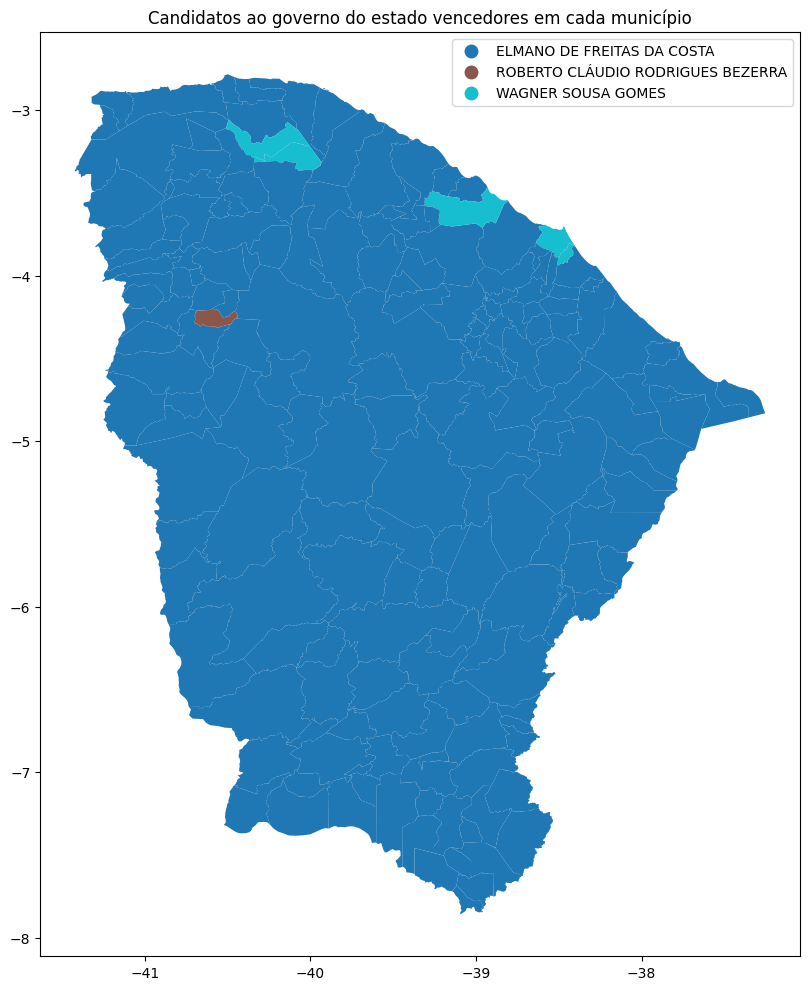

In [33]:
ax = vencedores_por_municipio.plot(
    column= 'nm_votavel', 
    legend= True, figsize= (18, 12)
)
ax.set_title('Candidatos ao governo do estado vencedores em cada município')

* O mapa mostra o grande desempenho do candidato Elmano de Freitas, que apesar da vitória de Wagner Sousa em municípios importantes (Fortaleza, Eusério e São Gonçalo do Amarante), recebendo mais votos na maior parte das cidades cearenses.

## 4.2.3 Votos para governador nos municípios da Região Metropolitana de Fortaleza 

A Região Metropolitana de Fortaleza é constituída de 19 municípios sendo eles:

* Aquiraz, Cascavel, Caucaia, Chorozinho, Eusébio, Fortaleza, Guaiúba, Horizonte, Itaitinga, Maracanaú, Maranguape, Pacajus, Pacatuba, Pindoretama, São Gonçalo do Amarante, São Luís do Curu, Paraipaba, Paracuru e Trairi. 

Fonte: https://pt.wikipedia.org/wiki/Regi%C3%A3o_Metropolitana_de_Fortaleza


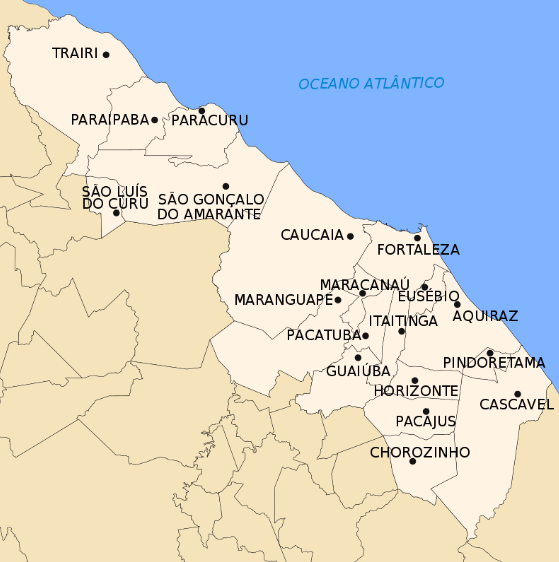

Instancia-se uma lista contendo o nome dos municípios da região metropolitana, todos eles em caixa alta:

In [34]:
regiao_metropolitana = [
    'AQUIRAZ', 'CASCAVEL', 'CAUCAIA', 'CHOROZINHO', 'EUSÉBIO', 
    'FORTALEZA', 'GUAIÚBA', 'HORIZONTE', 'ITAITINGA', 'MARACANAÚ', 
    'MARANGUAPE', 'PACAJUS', 'PACATUBA', 'PINDORETAMA', 
    'SÃO GONÇALO DO AMARANTE', 'SÃO LUÍS DO CURU',
    'PARAIPABA', 'PARACURU', 'TRAIRI'
]

### 4.2.3.1 Contribuição de cada município da Região Metropolitana de Fortaleza na eleição

In [35]:
# Os votos para cada município da região metropolitana são determinados agrupando-os e somando os votos:

votos_por_cidade_regiao_metropolitana = votacao_ce.query('ds_cargo == "GOVERNADOR" and nm_municipio in @regiao_metropolitana')\
                                                  .groupby('nm_municipio')['qt_votos'].sum().sort_values(ascending= False).to_frame()

# Também determinam-se o número total de votos em toda a região metropolitana:

votos_totais_regiao_metropolitana = votos_por_cidade_regiao_metropolitana['qt_votos'].sum()
print(f'A Região Metropolitana de Fortaleza concentra um total de {votos_totais_regiao_metropolitana} votos.')

A Região Metropolitana de Fortaleza concentra um total de 2468270 votos.


In [36]:
# Uma nova coluna é adicionada ao dataframe votos_por_cidade_regiao_metropolitana com os dados da porcentagem de votos de cada município em relação aos
# votos totais na Região Metropolitana de Fortaleza:

votos_por_cidade_regiao_metropolitana['porcentagem_votos_da_regiao'] = votos_por_cidade_regiao_metropolitana['qt_votos']/votos_totais_regiao_metropolitana
votos_por_cidade_regiao_metropolitana['porcentagem_votos_da_regiao'] = round((votos_por_cidade_regiao_metropolitana['porcentagem_votos_da_regiao'] * 100), 2)

In [37]:
fig = go.Figure()
fig.add_trace(
    go.Waterfall(
        x= votos_por_cidade_regiao_metropolitana.index, 
        y= votos_por_cidade_regiao_metropolitana['porcentagem_votos_da_regiao'])
)
fig.update_layout(
    title= 'Contribuição de votos, em porcentagem, dos municípios na Região Metropolitana de Fortaleza',
    title_x= 0.5, yaxis_title= 'Porcentagem', xaxis_title= 'Municípios'
)
fig.show()

* A cidade de Fortaleza sozinha é responsável por mais de 60% dos votos na Região Metropolitana de Fortaleza. É seguida pelos municípios de Caucaia (8,23%), Maracanaú (6,02%) e Maranguape (2,77%).

### 4.2.3.2 Desempenho eleitoral de cada candidato por município da Região Metropolitana de Fortaleza

Determina-se a quantidade de votos totais para governador em cada cidade da região metropolitana.

In [38]:
# Buscam-se os dados referentes a votação para governador e nos municípios da região metropolitana:

votos_por_cidade_regiao_metropolitana = votacao_ce.query('ds_cargo == "GOVERNADOR" and nm_municipio in @regiao_metropolitana')\
                                                  .groupby('nm_municipio')['qt_votos'].sum() # os dados são agrupados por município e os votos somados.
votos_por_cidade_regiao_metropolitana = dict(votos_por_cidade_regiao_metropolitana) 

Instanciam-se os votos por cidade da região metropolitana em um dicionário, como visualizado abaixo:

In [39]:
votos_por_cidade_regiao_metropolitana

{'AQUIRAZ': 52826,
 'CASCAVEL': 48165,
 'CAUCAIA': 203023,
 'CHOROZINHO': 14627,
 'EUSÉBIO': 42417,
 'FORTALEZA': 1559702,
 'GUAIÚBA': 16756,
 'HORIZONTE': 48963,
 'ITAITINGA': 25942,
 'MARACANAÚ': 148636,
 'MARANGUAPE': 68296,
 'PACAJUS': 44337,
 'PACATUBA': 44772,
 'PARACURU': 26088,
 'PARAIPABA': 21824,
 'PINDORETAMA': 15837,
 'SÃO GONÇALO DO AMARANTE': 38834,
 'SÃO LUÍS DO CURU': 9330,
 'TRAIRI': 37895}

Determinam-se os votos para cada candidato em cada um dos municípios da região metropolitana de Fortaleza.

In [40]:
# Buscam-se os dados referentes ao cargo de governador e das cidades da região metropolitana, estes são agrupados, os votos somados e os index resetados:

votos_regiao_metropolitana = votacao_ce.query('nm_municipio in @regiao_metropolitana and ds_cargo == "GOVERNADOR"')\
                                       .groupby(['nm_municipio', 'nm_votavel'])['qt_votos'].sum().reset_index()

# Os dados são ordenados em ordem alfabética do nome dos municípios e em ordem decrescente dos votos:

votos_regiao_metropolitana = votos_regiao_metropolitana.sort_values(['nm_municipio', 'qt_votos'], ascending= [True, False])

E, por fim, adicionam-se as porcentagens de votos para cada candidato naquela localidade:

In [41]:
porcentagem = list()

for index, row in votos_regiao_metropolitana.iterrows():
  # itera-se o dataframe e calcula-se a porcentagem dos votos a partir dos votos totais de cada município, informação presente no dicionário:

  valor = round((row['qt_votos'] / votos_por_cidade_regiao_metropolitana[row['nm_municipio']]) * 100, 2)
  porcentagem.append(valor) # os valores são colocados na lista porcentagem.

In [42]:
votos_regiao_metropolitana['porcentagem'] = porcentagem
votos_regiao_metropolitana

,nm_municipio,nm_votavel,qt_votos,porcentagem
0,AQUIRAZ,ELMANO DE FREITAS DA COSTA,25542,48.35
7,AQUIRAZ,WAGNER SOUSA GOMES,19229,36.40
3,AQUIRAZ,ROBERTO CLÁUDIO RODRIGUES BEZERRA,3721,7.04
6,AQUIRAZ,VOTO NULO,2643,5.00
5,AQUIRAZ,VOTO BRANCO,1643,3.11
...,...,...,...,...
150,TRAIRI,VOTO NULO,1768,4.67
149,TRAIRI,VOTO BRANCO,1259,3.32
145,TRAIRI,FRANCISCO RAIMUNDO MALTA DE ARAÚJO,11,0.03
146,TRAIRI,JOSÉ BATISTA NETO,9,0.02


O gráfico mostra a porcentagem dos votos para cada candidato (votos brancos e nulos inclusos) nos municípios da grande Fortaleza.

In [43]:
fig = px.bar(
    data_frame= votos_regiao_metropolitana,
    y= 'nm_municipio',
    x= 'porcentagem',
    color= 'nm_votavel', 
    title= 'Porcentagem dos votos por candidato para cada município da região metropolitana de Fortaleza'
)
fig.update_layout(
    legend_title= 'Candidatos', yaxis_title= 'Municípios', xaxis_title= 'Porcentagem dos votos',
    yaxis= dict(autorange= 'reversed'), title= dict(x= 0.5)
)
fig.show()

* Destaca-se o desempenho eleitoral do candidato Wagner Sousa em Fortaleza, Eusébio e São Gonçalo do Amarante. 
* Excetuando-se os municípios já citados, Elmano de Freitas saiu vencedor em todas as outras cidades.
* O melhor desempenho do candidato Roberto Cláudio na Grande Fortaleza ocorreu na capital, onde já foi prefeito.

### 4.2.3.3 Visualização no mapa da Região Metropolitana de Fortaleza

In [44]:
# Instancia-se um dataframe que contém apenas o candidato vencedor no município.

vencedor_regiao_metropolitana = votos_regiao_metropolitana.groupby('nm_municipio').head(1)

vencedor_regiao_metropolitana.head() # visualiza-se o dataframe

,nm_municipio,nm_votavel,qt_votos,porcentagem
0,AQUIRAZ,ELMANO DE FREITAS DA COSTA,25542,48.35
8,CASCAVEL,ELMANO DE FREITAS DA COSTA,23131,48.02
16,CAUCAIA,ELMANO DE FREITAS DA COSTA,87636,43.17
24,CHOROZINHO,ELMANO DE FREITAS DA COSTA,8504,58.14
39,EUSÉBIO,WAGNER SOUSA GOMES,18787,44.29


In [45]:
# É feito o 'merge' do dataframe com os votos na região metropolitana com os dados geoespaciais:

vencedor_regiao_metropolitana = pd.merge(
    left= ceara_gpd[['name_muni', 'geometry']], right= vencedor_regiao_metropolitana, 
    how= 'inner', left_on= 'name_muni', right_on= 'nm_municipio'
).drop('name_muni', axis= 1) # elimina-se a coluna 'name_muni', pois os dados são redundantes.

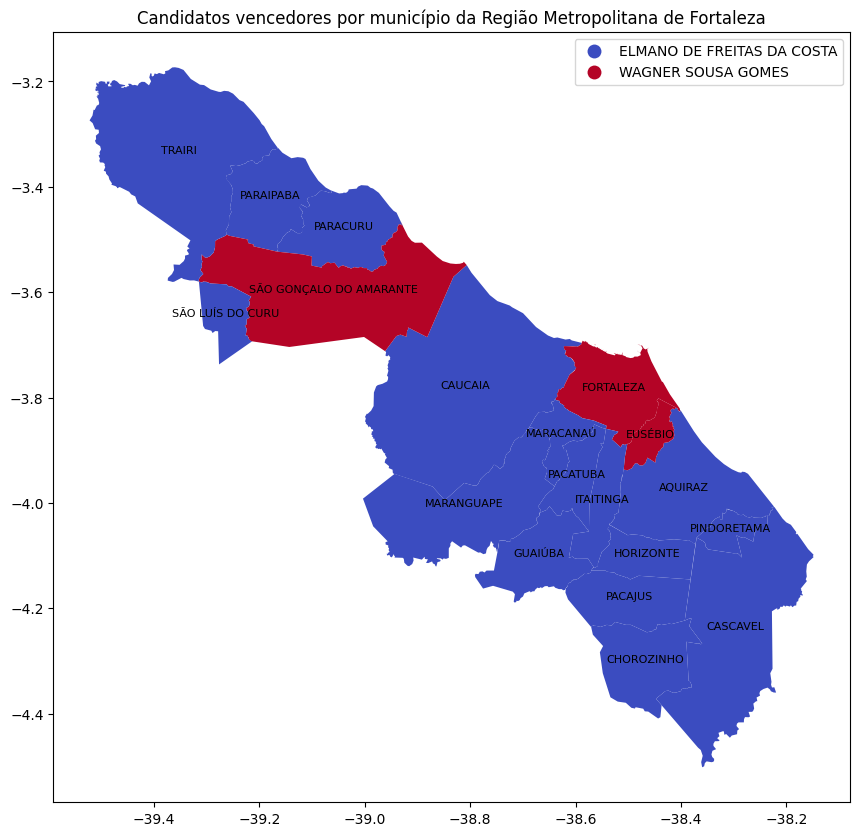

In [46]:
ax = vencedor_regiao_metropolitana.plot(
    'nm_votavel', categorical= True, legend= True, cmap= 'coolwarm', figsize= (12, 10),
)
ax.set_title('Candidatos vencedores por município da Região Metropolitana de Fortaleza')

for i, row in vencedor_regiao_metropolitana.iterrows():
    ax.annotate(text=row['nm_municipio'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize= 8)

plt.show()

Na Região Metropolitana de Fortaleza, dos 19 município apenas em 3 municípios (Fortaleza, Eusébio e São Gonçalo do Amarante) o candidato Wagner Sousa Gomes obteve maior quantidade de votos.

## 4.3 Análise com indicadores socioeconômicos do IBGE

Os dados de resumo do IBGE dos municípios cearenses são carregados:

In [47]:
dados_ibge = pd.read_csv(
    '/content/drive/MyDrive/Datasets/resumo_dados_ibge_ce.csv', encoding= 'latin-1'
)

In [48]:
dados_ibge.head()

,nome,area_territorio,populacao,idhm,pib_per_capita,area_urbanizada,porcentagem_urbana,densidade_populacional
0,ABAIARA,180.833,11965,0.628,9158.04,3.19,1.76,66.17
1,ACARAPE,130.002,15140,0.606,10317.47,2.28,1.75,116.46
2,ACARAÚ,842.471,63556,0.601,13261.89,16.33,1.94,75.44
3,ACOPIARA,2254.279,54687,0.595,9432.25,5.46,0.24,24.26
4,AIUABA,2438.563,17584,0.569,8642.90,2.07,0.08,7.21


Determina-se, também, a quantidade de votos para cada candidato em cada município cearense na célula abaixo. Além disso, unem-se os dois *dataframes*.

In [49]:
# Quantidade de votos por candidato em cada município cearense:

votos_por_municipio = votacao_ce.query('ds_cargo == "GOVERNADOR"').groupby(['nm_municipio', 'nm_votavel'])['qt_votos'].sum().reset_index()

# 'Merge' dos dados de ambos dataframes, de votos dos candidatos e resumo dos dados do IBGE:

votos_por_municipio = pd.merge(
    left= votos_por_municipio, right= dados_ibge, how= 'inner',
    left_on= 'nm_municipio', right_on= 'nome'
).drop('nome', axis= 1) # elimina-se a coluna 'nome', pois possui dados redundantes.

Por fim os dados são mostrados:

In [50]:
votos_por_municipio.head()

,nm_municipio,nm_votavel,qt_votos,area_territorio,populacao,idhm,pib_per_capita,area_urbanizada,porcentagem_urbana,densidade_populacional
0,ABAIARA,ELMANO DE FREITAS DA COSTA,4182,180.833,11965,0.628,9158.04,3.19,1.76,66.17
1,ABAIARA,FRANCISCO RAIMUNDO MALTA DE ARAÚJO,7,180.833,11965,0.628,9158.04,3.19,1.76,66.17
2,ABAIARA,JOSÉ BATISTA NETO,1,180.833,11965,0.628,9158.04,3.19,1.76,66.17
3,ABAIARA,ROBERTO CLÁUDIO RODRIGUES BEZERRA,353,180.833,11965,0.628,9158.04,3.19,1.76,66.17
4,ABAIARA,SERLEY DE SOUSA LEAL,3,180.833,11965,0.628,9158.04,3.19,1.76,66.17


### 4.3.1 Visualização do candidato vencedor por município em relação aos indicadores

In [51]:
dados_ibge = pd.merge(
    left= ceara_gpd[['name_muni', 'geometry']], right= dados_ibge,
    how= 'inner', left_on= 'name_muni', right_on= 'nome' 
)

dados_ibge = dados_ibge.drop('nome', axis= 1)

dados_ibge = dados_ibge.rename({'name_muni': 'nm_municipio'}, axis= 1)

#### 4.3.1.1 Densidade populacional

O conjunto de dados na coluna `densidade_populacional` é bastante discrepante. O município de Fortaleza concentra mais de 2,5 milhões de habitantes em território modesto, se comparado a outros municípios cearenses. Portanto, aplica-se transformação logarítimica nos dados da coluna a fim de facilitar a visualização no mapa:

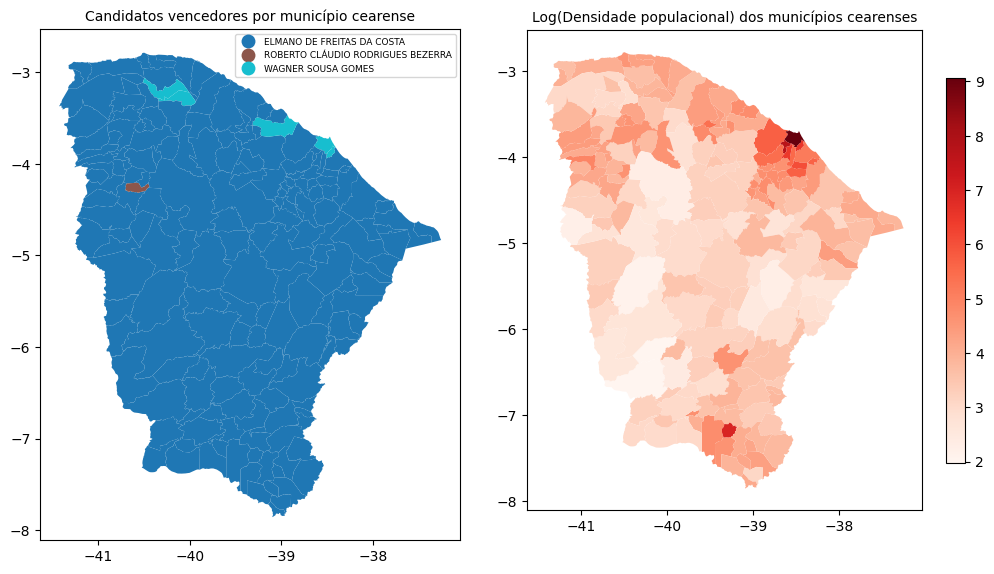

In [52]:
fig, ax = plt.subplots(1, 2, figsize= (14, 10))
ax1 = vencedores_por_municipio.plot(column= 'nm_votavel', categorical= True, legend= True, legend_kwds={'loc': 'upper right', 'fontsize': 6.5}, ax= ax[0])
ax1.set_title('Candidatos vencedores por município cearense', fontsize= 10)
ax[0].set_position([0.2, 0.1, 0.3, 0.761]) # modifica, individualmente, a posição do mapa na posição 0.
ax2 = dados_ibge.plot(
    np.log(dados_ibge['densidade_populacional']), cmap= 'Reds', legend= True, 
    legend_kwds= {'shrink': 0.5}, ax= ax[1] # shrink determina a diminuição do tamanho da legenda.
) 
ax2.set_title('Log(Densidade populacional) dos municípios cearenses', fontsize= 10)
plt.show()

#### 4.3.1.2 Indíce de desenvolvimento humano municipal (IDHM)

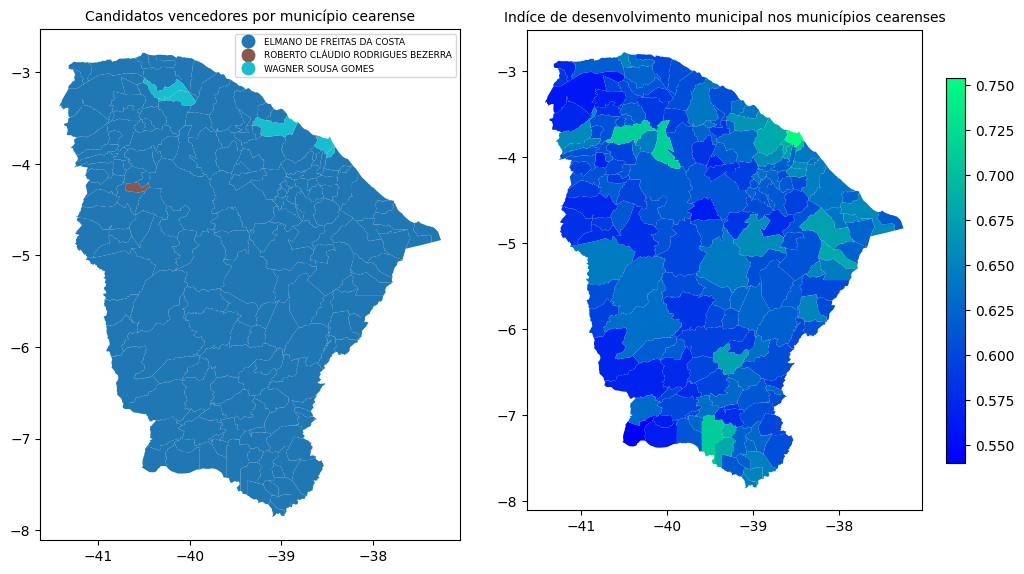

In [53]:
fig, ax = plt.subplots(1, 2, figsize= (14, 10))
ax1 = vencedores_por_municipio.plot(column= 'nm_votavel', categorical= True, legend= True, legend_kwds={'loc': 'upper right', 'fontsize': 6.5}, ax= ax[0])
ax1.set_title('Candidatos vencedores por município cearense', fontsize= 10)
ax[0].set_position([0.2, 0.1, 0.3, 0.761]) # modifica, individualmente, a posição do mapa na posição 0.
ax2 = dados_ibge.plot('idhm', cmap= 'winter', legend= True, legend_kwds= {'shrink': 0.5}, ax= ax[1]) # shrink determina a diminuição do tamanho da legenda.
ax2.set_title('Indíce de desenvolvimento municipal nos municípios cearenses', fontsize= 10)
plt.show()

#### 4.3.1.3 PIB *per capita*

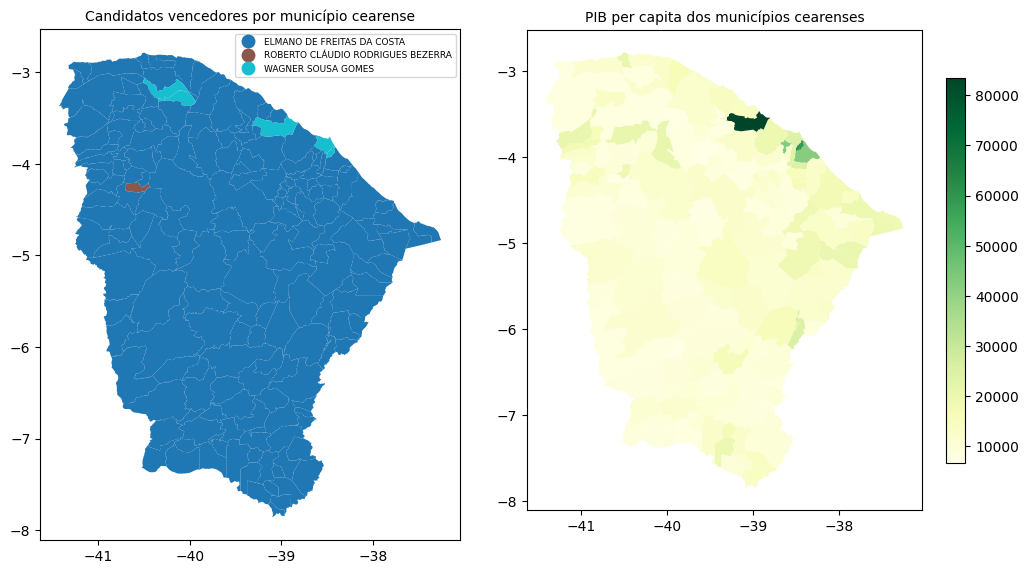

In [88]:
fig, ax = plt.subplots(1, 2, figsize= (14, 10))
ax1 = vencedores_por_municipio.plot(column= 'nm_votavel', categorical= True, legend= True, legend_kwds={'loc': 'upper right', 'fontsize': 6.5}, ax= ax[0])
ax1.set_title('Candidatos vencedores por município cearense', fontsize= 10)
ax[0].set_position([0.2, 0.1, 0.3, 0.761]) # modifica, individualmente, a posição do mapa na posição 0.
ax2 = dados_ibge.plot(
    'pib_per_capita', cmap= 'YlGn', legend= True, legend_kwds= {'shrink': 0.5}, ax= ax[1] # shrink determina a diminuição do tamanho da legenda.
) 
ax2.set_title('PIB per capita dos municípios cearenses', fontsize= 10)
plt.show()

#### 4.3.1.4 Área urbanizada

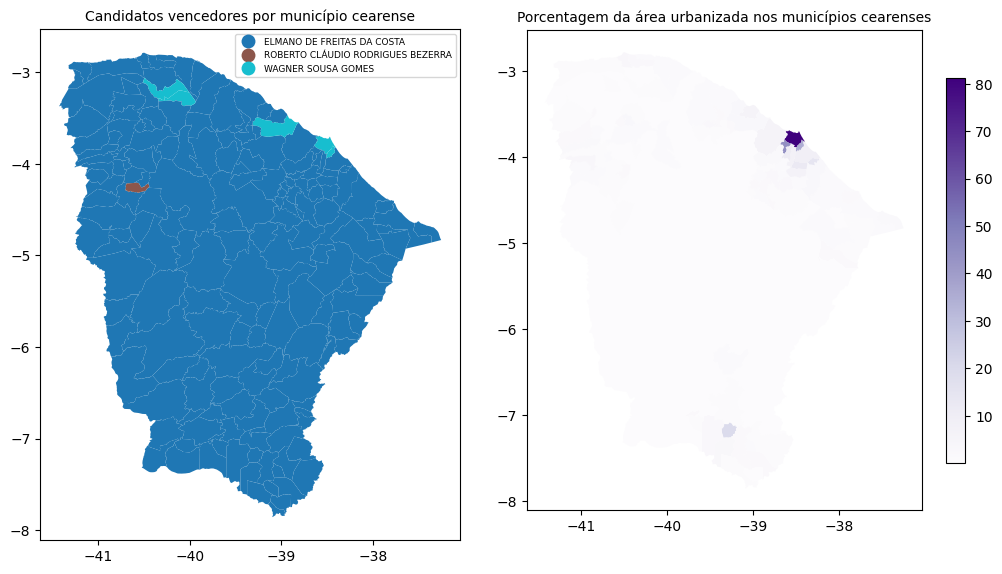

In [92]:
fig, ax = plt.subplots(1, 2, figsize= (14, 10))
ax1 = vencedores_por_municipio.plot(column= 'nm_votavel', categorical= True, legend= True, legend_kwds={'loc': 'upper right', 'fontsize': 6.5}, ax= ax[0])
ax1.set_title('Candidatos vencedores por município cearense', fontsize= 10)
ax[0].set_position([0.2, 0.1, 0.3, 0.761]) # modifica, individualmente, a posição do mapa na posição 0.
ax2 = dados_ibge.plot(
    'porcentagem_urbana', cmap= 'Purples', legend= True, 
    legend_kwds= {'shrink': 0.5}, ax= ax[1] # shrink determina a diminuição do tamanho da legenda.
) 
ax2.set_title('Porcentagem da área urbanizada nos municípios cearenses', fontsize= 10)
plt.show()

### 4.3.2 Correlação entre votos e os indíces socioeconômicos do IBGE

#### 4.3.2.1 Densidade populacional

In [100]:
fig = make_subplots(rows= 1, cols= 3, subplot_titles= ['Elmano de Freitas', 'Wagner Sousa', 'Roberto Cláudio'])

fig.add_trace(
    go.Scatter(x= np.log(votos_por_municipio.query('nm_votavel == "ELMANO DE FREITAS DA COSTA"')['densidade_populacional']), 
               y= votos_por_municipio.query('nm_votavel == "ELMANO DE FREITAS DA COSTA"')['porcentagem_dos_votos'],
               mode= 'markers'), row= 1, col= 1
)
fig.add_trace(
    go.Scatter(x= np.log(votos_por_municipio.query('nm_votavel == "WAGNER SOUSA GOMES"')['densidade_populacional']), 
               y= votos_por_municipio.query('nm_votavel == "WAGNER SOUSA GOMES"')['porcentagem_dos_votos'],
               mode= 'markers'), row= 1, col= 2
)
fig.add_trace(
    go.Scatter(x= np.log(votos_por_municipio.query('nm_votavel == "ROBERTO CLÁUDIO RODRIGUES BEZERRA"')['densidade_populacional']), 
               y= votos_por_municipio.query('nm_votavel == "ROBERTO CLÁUDIO RODRIGUES BEZERRA"')['porcentagem_dos_votos'],
               mode= 'markers'), row= 1, col= 3
)
fig.update_layout(showlegend= False)
fig.update_yaxes(title_text= 'Porcentagem dos votos', row= 1, col=1)
fig.update_xaxes(title_text= 'log(Densidade populacional)', row= 1, col= 1)
fig.update_xaxes(title_text= 'log(Densidade populacional)', row= 1, col= 2)
fig.update_xaxes(title_text= 'log(Densidade populacional)', row= 1, col= 3)
fig.show()

#### 4.3.2.2 Indíce de desenvolvimento urbana municipal

In [95]:
fig = make_subplots(rows= 1, cols= 3, subplot_titles= ['Elmano de Freitas', 'Wagner Sousa', 'Roberto Cláudio'])

fig.add_trace(
    go.Scatter(x= votos_por_municipio.query('nm_votavel == "ELMANO DE FREITAS DA COSTA"')['idhm'], 
               y= votos_por_municipio.query('nm_votavel == "ELMANO DE FREITAS DA COSTA"')['porcentagem_dos_votos'],
               mode= 'markers'), row= 1, col= 1
)
fig.add_trace(
    go.Scatter(x= votos_por_municipio.query('nm_votavel == "WAGNER SOUSA GOMES"')['idhm'], 
               y= votos_por_municipio.query('nm_votavel == "WAGNER SOUSA GOMES"')['porcentagem_dos_votos'],
               mode= 'markers'), row= 1, col= 2
)
fig.add_trace(
    go.Scatter(x= votos_por_municipio.query('nm_votavel == "ROBERTO CLÁUDIO RODRIGUES BEZERRA"')['idhm'], 
               y= votos_por_municipio.query('nm_votavel == "ROBERTO CLÁUDIO RODRIGUES BEZERRA"')['porcentagem_dos_votos'],
               mode= 'markers'), row= 1, col= 3
)
fig.update_layout(showlegend= False)
fig.update_yaxes(title_text= 'Porcentagem dos votos', row= 1, col=1)
fig.update_xaxes(title_text= 'IDHM', row= 1, col= 1)
fig.update_xaxes(title_text= 'IDHM', row= 1, col= 2)
fig.update_xaxes(title_text= 'IDHM', row= 1, col= 3)
fig.show()

#### 4.3.2.3 PIB *per capita*

In [101]:
fig = make_subplots(rows= 1, cols= 3, subplot_titles= ['Elmano de Freitas', 'Wagner Sousa', 'Roberto Cláudio'])

fig.add_trace(
    go.Scatter(x= np.log(votos_por_municipio.query('nm_votavel == "ELMANO DE FREITAS DA COSTA"')['pib_per_capita']), 
               y= votos_por_municipio.query('nm_votavel == "ELMANO DE FREITAS DA COSTA"')['porcentagem_dos_votos'],
               mode= 'markers'), row= 1, col= 1
)
fig.add_trace(
    go.Scatter(x= np.log(votos_por_municipio.query('nm_votavel == "WAGNER SOUSA GOMES"')['pib_per_capita']), 
               y= votos_por_municipio.query('nm_votavel == "WAGNER SOUSA GOMES"')['porcentagem_dos_votos'],
               mode= 'markers'), row= 1, col= 2
)
fig.add_trace(
    go.Scatter(x= np.log(votos_por_municipio.query('nm_votavel == "ROBERTO CLÁUDIO RODRIGUES BEZERRA"')['pib_per_capita']), 
               y= votos_por_municipio.query('nm_votavel == "ROBERTO CLÁUDIO RODRIGUES BEZERRA"')['porcentagem_dos_votos'],
               mode= 'markers'), row= 1, col= 3
)
fig.update_layout(showlegend= False)
fig.update_yaxes(title_text= 'Porcentagem dos votos', row= 1, col=1)
fig.update_xaxes(title_text= 'IDHM', row= 1, col= 1)
fig.update_xaxes(title_text= 'IDHM', row= 1, col= 2)
fig.update_xaxes(title_text= 'IDHM', row= 1, col= 3)
fig.show()

### 4.3.2 Análise estratificada por intervalo populacional

Três funções são criadas a fim de realizar a análise por intervalos dos indicadores socioeconômicos.

In [56]:
def intervalos_ibge(dataframe: pd.DataFrame, nome_coluna: str, nova_coluna: str, bins: list, labels: list):
  """""
  A função 'intervalos_ibge' adiciona ao dataframe com os votos dos candidatos por município uma nova coluna. Tal coluna passa a conter um intervalo 
  pré-determinado determinado indicador do IBGE relacionado ao município em questão.

  * dataframe: dataframe contendo os votos por candidato em cada município.
  * nome_coluna: coluna com a informação que será utilizada para gerar o intervalo.
  * nova_coluna: nome da nova coluna contendo os intervalos dos indicadores do IBGE.
  * bins: lista com os valores que serão usados para formar os intervalos dos indicadores.
  * labels: lista com as labels dos intervalos.
  """""
  dataframe[nova_coluna] = pd.cut(
      dataframe[nome_coluna], bins= bins, labels= labels,
      include_lowest= True, right= False # o valor mais baixo é incluso, enquanto o valor maior não é incluso.
  )

  return dataframe # retorna o dataframe, agora contendo a coluna com os intervalos dos indicadores do IBGE.

def dict_votos_totais(dataframe: pd.DataFrame, coluna_indicador: str):
  """""
  A função dict_votos_totais retorna um dicionário com a quantidade de votos gerais para cada intervalo dos indicadores do IBGE.

  * dataframe: contendo os votos por candidato em cada município, além da coluna com os intervalos dos indicadores.
  * coluna_indicador: nome da coluna contendo os intervalos dos indicadores.
  """""
  valores_totais = dataframe.groupby(coluna_indicador)['qt_votos'].sum()
  valores_totais = dict(valores_totais)
  
  return valores_totais

def dataframe_com_porcentagens(dataframe: pd.DataFrame, dictionary: dict, coluna_indicador: str):
  """""
  A função dataframe_com_porcentagens retorna um dataframe contendo a porcentagem de votos para cada candidato referente a cada intervalo de indicador.
  * dataframe: dataframe com votos dos candidatos por municípios.
  * dictionary: dicionário contendo os votos totais de cada intervalo de indicador do IBGE.
  * coluna_indicador: coluna com o indicador do IBGE que se deseja calcular os valores de porcentagem.
  """""

  # O dataframe é agrupado pela coluna com os indicadores e nome dos candidatos, os votos são somados e ordenados:

  dataframe_intervalos_ibge = dataframe.groupby([coluna_indicador, 'nm_votavel'])['qt_votos'].sum()\
                                       .reset_index().sort_values([coluna_indicador, 'qt_votos'], ascending= [True, False])

  # A porcentagem para cada candidado em cada intervalo do indicador é calculada:

  porcentagem = list()

  for index, row in dataframe_intervalos_ibge.iterrows():
    valor = round((row['qt_votos']/dictionary[row[coluna_indicador]]) * 100, 2)
    porcentagem.append(valor)
  
  # E depois uma nova coluna é adicionada ao dataframe que é retornado:

  dataframe_intervalos_ibge['porcentagem_' + coluna_indicador] = porcentagem # o nome da coluna é obtido a partir da concatenação das strings.

  return dataframe_intervalos_ibge

Determinam-se os intervalos populacionais dos municípios para análise. Ademais, as *labels* também são definidas.

In [57]:
bins = [0, 100000, 500000, 3000000]
labels = ['Menos de 100 mil habitantes', '100 mil e menos de 500 mil habitantes', '500 mil habitantes ou mais']

A coluna com intervalos populacionais é adicionada ao *dataframe*.

In [58]:
votos_por_municipio = intervalos_ibge(
    dataframe= votos_por_municipio, 
    nome_coluna= 'populacao', 
    nova_coluna= 'populacao_intervalos',
    bins= bins, labels= labels
)

votos_por_municipio.head(2)

,nm_municipio,nm_votavel,qt_votos,area_territorio,populacao,idhm,pib_per_capita,area_urbanizada,porcentagem_urbana,densidade_populacional,populacao_intervalos
0,ABAIARA,ELMANO DE FREITAS DA COSTA,4182,180.833,11965,0.628,9158.04,3.19,1.76,66.17,Menos de 100 mil habitantes
1,ABAIARA,FRANCISCO RAIMUNDO MALTA DE ARAÚJO,7,180.833,11965,0.628,9158.04,3.19,1.76,66.17,Menos de 100 mil habitantes


O número de votos totais por intervalo populacional é computado.

In [59]:
votos_totais_por_intervalo_populacional = dict_votos_totais(votos_por_municipio, 'populacao_intervalos')
votos_totais_por_intervalo_populacional

{'Menos de 100 mil habitantes': 3146126,
 '100 mil e menos de 500 mil habitantes': 917622,
 '500 mil habitantes ou mais': 1559702}

Os municípios com menos de 100 mil habitantes são aqueles que concentram a maior soma de votos totais. Mais de 1,5 milhão de votos são contabilizados nos municípios com mais de 500 mil habitantes, que nesse caso é apenas o município de Fortaleza.

A porcentagem de votos para cada candidado em intervalo populacional é calculada. Ademais, alguns valores são mostrados na tabela abaixo.

In [60]:
votos_intervalos_populacionais = dataframe_com_porcentagens(
    votos_por_municipio, votos_totais_por_intervalo_populacional, 'populacao_intervalos'    
)
votos_intervalos_populacionais.head()

,populacao_intervalos,nm_votavel,qt_votos,porcentagem_populacao_intervalos
0,Menos de 100 mil habitantes,ELMANO DE FREITAS DA COSTA,1780609,56.60
7,Menos de 100 mil habitantes,WAGNER SOUSA GOMES,766806,24.37
3,Menos de 100 mil habitantes,ROBERTO CLÁUDIO RODRIGUES BEZERRA,356644,11.34
6,Menos de 100 mil habitantes,VOTO NULO,139194,4.42
5,Menos de 100 mil habitantes,VOTO BRANCO,100497,3.19


O gráfico mostra os resultados obtidos:

In [61]:
fig = px.bar(
    data_frame= votos_intervalos_populacionais,
    y= 'populacao_intervalos',
    x= 'porcentagem_populacao_intervalos',
    color= 'nm_votavel',
    title= 'Porcentagem de votos dos candidatos por intervalo populacional dos municípios cearenses'
)
fig.update_layout(
    yaxis_title= '', xaxis_title= 'Porcentagem dos votos', legend_title= 'Candidatos',
    yaxis= dict(autorange= 'reversed'), title= dict(x= 0.5)
)
fig.show()

* O candidato Elmano de Freitas recebeu 56,6% dos votos dos municípios com menos de 100 mil habitantes. 

* Enquanto o candidato Wagner Sousa Gomes apresentou melhor desempenho em cidades com mais habitantes. Ultrapassando o candidato Elmano em cidades com mais de 500 mil habitantes (no caso, Fortaleza, onde foi vencedor).

* Os votos foram mais expressivos para o candidato Roberto Claúdio em cidades maiores (Fortaleza), vale ressaltar que o candidato foi prefeito da capital cearense.

### 4.3.3 Análise estratificada por IDHM

Os intervalos para a análise do Indíce de desenvolvimento humano municipal são definidos, e as *labels* também.

In [62]:
bins = [0, 0.55, 0.7, 0.8]
labels = ['IDH baixo', 'IDH médio', 'IDH alto']

A coluna com intervalos do IDHM (`idhm_intervalos`) é adicionada ao *dataframe*.

In [63]:
votos_por_municipio = intervalos_ibge(
    dataframe= votos_por_municipio,
    nome_coluna= 'idhm',
    nova_coluna= 'idhm_intervalos',
    bins= bins, labels= labels
)

votos_por_municipio.head(2)

,nm_municipio,nm_votavel,qt_votos,area_territorio,populacao,idhm,pib_per_capita,area_urbanizada,porcentagem_urbana,densidade_populacional,populacao_intervalos,idhm_intervalos
0,ABAIARA,ELMANO DE FREITAS DA COSTA,4182,180.833,11965,0.628,9158.04,3.19,1.76,66.17,Menos de 100 mil habitantes,IDH médio
1,ABAIARA,FRANCISCO RAIMUNDO MALTA DE ARAÚJO,7,180.833,11965,0.628,9158.04,3.19,1.76,66.17,Menos de 100 mil habitantes,IDH médio


Os votos totais para cada intervalo são determinados e contidos num dicionário como mostrado abaixo:

In [64]:
votos_totais_por_intervalo_idhm = dict_votos_totais(votos_por_municipio, 'idhm_intervalos')
votos_totais_por_intervalo_idhm

{'IDH baixo': 11019, 'IDH médio': 3804659, 'IDH alto': 1807772}

A maior parte dos votos está concentrada nos municípios com IDH municipal médio (3,8 milhões de votos). As cidades com IDH alto (Fortaleza, Eusébio, Sobral e Crato) são responsáveis por 1,8 milhão de votos. Enquanto o município de Salitre é o único com IDH baixo.

A maior parte dos municípios cearenses está contida no intervalo de IDH médio. Apenas uma cidade tem IDH baixo e quatro cidades IDH alto:

In [65]:
# Cidade com IDH baixo:

votos_por_municipio.query('idhm_intervalos == "IDH baixo"')['nm_municipio'].unique()

array(['SALITRE'], dtype=object)

In [66]:
# Quais as cidades com IDH alto?

votos_por_municipio.query('idhm_intervalos == "IDH alto"')['nm_municipio'].unique()

array(['CRATO', 'EUSÉBIO', 'FORTALEZA', 'SOBRAL'], dtype=object)

A porcentagem de votos dos candidatos para cada intervalo é determinada e adicionada e o *dataframe* `votos_intervalos_idhm` é instanciado.

In [67]:
votos_intervalos_idhm = dataframe_com_porcentagens(
    dataframe= votos_por_municipio, dictionary= votos_totais_por_intervalo_idhm,
    coluna_indicador= 'idhm_intervalos'
)
votos_intervalos_idhm.head()

,idhm_intervalos,nm_votavel,qt_votos,porcentagem_idhm_intervalos
0,IDH baixo,ELMANO DE FREITAS DA COSTA,6103,55.39
3,IDH baixo,ROBERTO CLÁUDIO RODRIGUES BEZERRA,3089,28.03
7,IDH baixo,WAGNER SOUSA GOMES,1226,11.13
6,IDH baixo,VOTO NULO,385,3.49
5,IDH baixo,VOTO BRANCO,209,1.90


O gráfico mostra os resultados obtidos:

In [68]:
fig = px.bar(
    data_frame= votos_intervalos_idhm,
    y= 'idhm_intervalos',
    x= 'porcentagem_idhm_intervalos',
    color= 'nm_votavel',
    title= 'Porcentagem de votos dos candidatos por intervalo de IDH municipal dos municípios cearenses'
)
fig.update_layout(
    xaxis_title= '', yaxis_title= 'Porcentagem dos votos', legend_title= 'Candidatos', 
    yaxis= dict(autorange= 'reversed'), title= dict(x= 0.5)
)
fig.show()

* O candidato Roberto Cláudio teve desempenho considerável em relação ao candidato Wagner Sousa em Salitre (município com IDH baixo). Enquanto o seu desempenho nos municípios com IDH médio, que formam a maioria, foi inferior. Em cidades com IDH mais alto teve uma retomada no desempenho.

* O candidato Elmano de Freitas manteve o desempenho entre os intervalos de IDH baixo e médio. Porém, perdeu força nos municípios com IDH mais elevado.

* Wagner Sousa teve desempenho melhor entre os municípios com o IDH médio e alto. O resultado do candidato nos municípios com maior IDH foi equivalente ao candidato Elmano de Freitas. 

### 4.3.4 Análise estratificada por PIB *per capita*

Os valores para os intervalos de PIB *per capita* e *labels* são definidos.

In [69]:
bins = [0, 10000, 20000, 90000]
labels = ['Menos de R$ 10000', 'Entre R$ 10000 - 19999,99', 'R$ 20000 ou mais']

A coluna com intervalos do PIB *per capita* (`pib_intervalos`) é adicionada ao *dataframe*.

In [70]:
votos_por_municipio = intervalos_ibge(
    dataframe= votos_por_municipio, nome_coluna= 'pib_per_capita',
    nova_coluna= 'pib_intervalos', bins= bins, labels= labels
)
votos_por_municipio.head(2)

,nm_municipio,nm_votavel,qt_votos,area_territorio,populacao,idhm,pib_per_capita,area_urbanizada,porcentagem_urbana,densidade_populacional,populacao_intervalos,idhm_intervalos,pib_intervalos
0,ABAIARA,ELMANO DE FREITAS DA COSTA,4182,180.833,11965,0.628,9158.04,3.19,1.76,66.17,Menos de 100 mil habitantes,IDH médio,Menos de R$ 10000
1,ABAIARA,FRANCISCO RAIMUNDO MALTA DE ARAÚJO,7,180.833,11965,0.628,9158.04,3.19,1.76,66.17,Menos de 100 mil habitantes,IDH médio,Menos de R$ 10000


Os votos totais por intervalo de PIB *per capita* são adicionados ao dicionário `votos_totais_por_intervalo_pib`.

In [71]:
votos_totais_por_intervalo_pib = dict_votos_totais(votos_por_municipio, 'pib_intervalos')
votos_totais_por_intervalo_pib

{'Menos de R$ 10000': 1131888,
 'Entre R$ 10000 - 19999,99': 2321911,
 'R$ 20000 ou mais': 2169651}

Os votos estão majoritariamente distribuídos entre os municípios com R$ 10000,00 ou mais de PIB *per capita*.

A porcentagem de votos dos candidatos para cada intervalo é determinada e adicionada, o *dataframe* `votos_intervalos_pib` é instanciado.

In [72]:
votos_intervalos_pib = dataframe_com_porcentagens(
    votos_por_municipio, dictionary= votos_totais_por_intervalo_pib,
    coluna_indicador= 'pib_intervalos'
)
votos_intervalos_pib.head()

,pib_intervalos,nm_votavel,qt_votos,porcentagem_pib_intervalos
0,Menos de R$ 10000,ELMANO DE FREITAS DA COSTA,695973,61.49
7,Menos de R$ 10000,WAGNER SOUSA GOMES,230315,20.35
3,Menos de R$ 10000,ROBERTO CLÁUDIO RODRIGUES BEZERRA,123559,10.92
6,Menos de R$ 10000,VOTO NULO,48056,4.25
5,Menos de R$ 10000,VOTO BRANCO,33166,2.93


O gráfico mostra os resultados obtidos:

In [73]:
fig = px.bar(
    data_frame= votos_intervalos_pib,
    y= 'pib_intervalos',
    x= 'porcentagem_pib_intervalos',
    color= 'nm_votavel',
    title= 'Porcentagem dos votos por candidato para cada intervalo de PIB per capita'
)
fig.update_layout(
    title= dict(x= 0.5), yaxis_title= '', xaxis_title= 'Porcentagem dos votos', legend_title= 'Candidatos',
    yaxis= dict(autorange= 'reversed')
)
fig.show()

### 4.3.5 Análise estratificada por urbanização

Os valores para os intervalos de taxa de urbanização do município e *labels* são definidos.

In [74]:
bins= [0, 10, 40, 90]
labels= ['Menos de 10%', 'Entre 10 - 39,99%', '40% ou mais']

A coluna com intervalos da taxa de urbanizacao (`taxa_urbanizacao_intervalos`) é adicionada ao *dataframe*.

In [75]:
votos_por_municipio = intervalos_ibge(
    votos_por_municipio, nome_coluna= 'porcentagem_urbana', 
    nova_coluna= 'taxa_urbanizacao_intervalos',
    bins= bins, labels= labels
)
votos_por_municipio.head(2)

,nm_municipio,nm_votavel,qt_votos,area_territorio,populacao,idhm,pib_per_capita,area_urbanizada,porcentagem_urbana,densidade_populacional,populacao_intervalos,idhm_intervalos,pib_intervalos,taxa_urbanizacao_intervalos
0,ABAIARA,ELMANO DE FREITAS DA COSTA,4182,180.833,11965,0.628,9158.04,3.19,1.76,66.17,Menos de 100 mil habitantes,IDH médio,Menos de R$ 10000,Menos de 10%
1,ABAIARA,FRANCISCO RAIMUNDO MALTA DE ARAÚJO,7,180.833,11965,0.628,9158.04,3.19,1.76,66.17,Menos de 100 mil habitantes,IDH médio,Menos de R$ 10000,Menos de 10%


Os votos totais por intervalo de taxa de urbanização são adicionados ao dicionário `votos_totais_por_intervalo_urbanizacao`.

In [76]:
votos_totais_por_intervalo_urbanizacao = dict_votos_totais(votos_por_municipio, 'taxa_urbanizacao_intervalos')
votos_totais_por_intervalo_urbanizacao

{'Menos de 10%': 3608699, 'Entre 10 - 39,99%': 306413, '40% ou mais': 1708338}

Os votos são concentrados em municípios com menos urbanização.

A porcentagem de votos dos candidatos para cada intervalo é determinada e adicionada, o *dataframe* `votos_intervalos_urbanizacao` é instanciado.

In [77]:
votos_intervalos_urbanizacao = dataframe_com_porcentagens(
    votos_por_municipio, dictionary= votos_totais_por_intervalo_urbanizacao,
    coluna_indicador= 'taxa_urbanizacao_intervalos'
)
votos_intervalos_urbanizacao.head()

,taxa_urbanizacao_intervalos,nm_votavel,qt_votos,porcentagem_taxa_urbanizacao_intervalos
0,Menos de 10%,ELMANO DE FREITAS DA COSTA,2033247,56.34
7,Menos de 10%,WAGNER SOUSA GOMES,890869,24.69
3,Menos de 10%,ROBERTO CLÁUDIO RODRIGUES BEZERRA,404290,11.20
6,Menos de 10%,VOTO NULO,159683,4.42
5,Menos de 10%,VOTO BRANCO,117714,3.26


Os resultados obtidos são mostrados no gráfico:

In [78]:
fig = px.bar(
    data_frame= votos_intervalos_urbanizacao,
    y= 'taxa_urbanizacao_intervalos',
    x= 'porcentagem_taxa_urbanizacao_intervalos',
    color= 'nm_votavel',
    title= 'Porcentagem dos votos por candidato para cada intervalo de urbanização dos municípios'
)
fig.update_layout(
    yaxis= dict(autorange= 'reversed'), yaxis_title= '', 
    xaxis_title= 'Porcentagem dos votos', title= dict(x= 0.5),
    legend_title= 'Candidatos'
)
fig.show()

* O candidato Roberto Cláudio teve melhor desempenho eleitoral nos municípios com 40% ou mais de área urbanizada. Mais uma vez é importante lembrar que ele foi prefeito da capital cearense.

* O candidato Elmano de Freitas teve desempenho eleitoral próximo entre os municípios os intervalos menores que 40% de área urbanizada. Em municípios mais urbanizados o candidato Wagner Sousa ultrapassou Elmano de Freitas.

In [79]:
votos_totais_por_municipio = votacao_ce.query('ds_cargo == "GOVERNADOR"').groupby('nm_municipio')['qt_votos'].sum()
votos_totais_por_municipio = dict(votos_totais_por_municipio)

In [80]:
list(votos_totais_por_municipio.items())[:5]

[('ABAIARA', 5918),
 ('ACARAPE', 10026),
 ('ACARAÚ', 36725),
 ('ACOPIARA', 30972),
 ('AIUABA', 8661)]

In [81]:
votos_por_municipio.head()

,nm_municipio,nm_votavel,qt_votos,area_territorio,populacao,idhm,pib_per_capita,area_urbanizada,porcentagem_urbana,densidade_populacional,populacao_intervalos,idhm_intervalos,pib_intervalos,taxa_urbanizacao_intervalos
0,ABAIARA,ELMANO DE FREITAS DA COSTA,4182,180.833,11965,0.628,9158.04,3.19,1.76,66.17,Menos de 100 mil habitantes,IDH médio,Menos de R$ 10000,Menos de 10%
1,ABAIARA,FRANCISCO RAIMUNDO MALTA DE ARAÚJO,7,180.833,11965,0.628,9158.04,3.19,1.76,66.17,Menos de 100 mil habitantes,IDH médio,Menos de R$ 10000,Menos de 10%
2,ABAIARA,JOSÉ BATISTA NETO,1,180.833,11965,0.628,9158.04,3.19,1.76,66.17,Menos de 100 mil habitantes,IDH médio,Menos de R$ 10000,Menos de 10%
3,ABAIARA,ROBERTO CLÁUDIO RODRIGUES BEZERRA,353,180.833,11965,0.628,9158.04,3.19,1.76,66.17,Menos de 100 mil habitantes,IDH médio,Menos de R$ 10000,Menos de 10%
4,ABAIARA,SERLEY DE SOUSA LEAL,3,180.833,11965,0.628,9158.04,3.19,1.76,66.17,Menos de 100 mil habitantes,IDH médio,Menos de R$ 10000,Menos de 10%


In [82]:
porcentagem_dos_votos = list()

for index, row in votos_por_municipio.iterrows():
  valor = round((row['qt_votos'] / votos_totais_por_municipio[row['nm_municipio']]) * 100, 2)
  porcentagem_dos_votos.append(valor)

votos_por_municipio['porcentagem_dos_votos'] = porcentagem_dos_votos

In [83]:
votos_por_municipio['densidade_populacional'] = votos_por_municipio['populacao'] / votos_por_municipio['area_territorio']

In [84]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [85]:
fig = make_subplots(rows= 1, cols= 3, subplot_titles= ['Elmano de Freitas', 'Wagner Sousa', 'Roberto Cláudio'])

fig.add_trace(
    go.Scatter(x= votos_por_municipio.query('nm_votavel == "ELMANO DE FREITAS DA COSTA"')['idhm'], 
               y= votos_por_municipio.query('nm_votavel == "ELMANO DE FREITAS DA COSTA"')['porcentagem_dos_votos'],
               mode= 'markers'), row= 1, col= 1
)
fig.add_trace(
    go.Scatter(x= votos_por_municipio.query('nm_votavel == "WAGNER SOUSA GOMES"')['idhm'], 
               y= votos_por_municipio.query('nm_votavel == "WAGNER SOUSA GOMES"')['porcentagem_dos_votos'],
               mode= 'markers'), row= 1, col= 2
)
fig.add_trace(
    go.Scatter(x= votos_por_municipio.query('nm_votavel == "ROBERTO CLÁUDIO RODRIGUES BEZERRA"')['idhm'], 
               y= votos_por_municipio.query('nm_votavel == "ROBERTO CLÁUDIO RODRIGUES BEZERRA"')['porcentagem_dos_votos'],
               mode= 'markers'), row= 1, col= 3
)
fig.update_layout(showlegend= False)
fig.update_yaxes(title_text= 'Porcentagem dos votos', row= 1, col=1)
fig.update_xaxes(title_text= 'IDHM', row= 1, col= 1)
fig.update_xaxes(title_text= 'IDHM', row= 1, col= 2)
fig.update_xaxes(title_text= 'IDHM', row= 1, col= 3)
fig.show()

In [86]:
fig = make_subplots(rows= 1, cols= 3, subplot_titles= ['Elmano de Freitas', 'Wagner Sousa', 'Roberto Cláudio'])

fig.add_trace(
    go.Scatter(x= votos_por_municipio.query('nm_votavel == "ELMANO DE FREITAS DA COSTA"')['pib_per_capita'], 
               y= votos_por_municipio.query('nm_votavel == "ELMANO DE FREITAS DA COSTA"')['porcentagem_dos_votos'],
               mode= 'markers'), row= 1, col= 1
)
fig.add_trace(
    go.Scatter(x= votos_por_municipio.query('nm_votavel == "WAGNER SOUSA GOMES"')['pib_per_capita'], 
               y= votos_por_municipio.query('nm_votavel == "WAGNER SOUSA GOMES"')['porcentagem_dos_votos'],
               mode= 'markers'), row= 1, col= 2
)
fig.add_trace(
    go.Scatter(x= votos_por_municipio.query('nm_votavel == "ROBERTO CLÁUDIO RODRIGUES BEZERRA"')['pib_per_capita'], 
               y= votos_por_municipio.query('nm_votavel == "ROBERTO CLÁUDIO RODRIGUES BEZERRA"')['porcentagem_dos_votos'],
               mode= 'markers'), row= 1, col= 3
)
fig.update_layout(showlegend= False)
fig.update_yaxes(title_text= 'Porcentagem dos votos', row= 1, col=1)
fig.update_xaxes(title_text= 'IDHM', row= 1, col= 1)
fig.update_xaxes(title_text= 'IDHM', row= 1, col= 2)
fig.update_xaxes(title_text= 'IDHM', row= 1, col= 3)
fig.show()